Lets see if we can train to memorize one image?

In [1]:
import torch
import numpy as np
from PIL import Image
from torchvision import transforms
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

In [2]:
f_img = '/Users/kuba/Documents/data/Raw/Face-Detection-Dataset/images/train/0a0d7a87378422e3.jpg'
f_label = '/Users/kuba/Documents/data/Raw/Face-Detection-Dataset/labels/train/0a0d7a87378422e3.txt'

In [3]:
image = Image.open(f_img)

# normalizes 0 to 1
transform = transforms.ToTensor()
img_tensor = transform(image) 

with open(f_label, 'r') as f:
    label = f.readline().strip()  
    bbox = torch.tensor([float(x) for x in label.split()])

print("Image tensor shape:", img_tensor.shape)
print("Label tensor:", bbox)

Image tensor shape: torch.Size([3, 1024, 683])
Label tensor: tensor([0.0000, 0.5076, 0.3823, 0.5736, 0.5206])


In [50]:
def calculate_center_coordinates(im, bbox_pred):
    center_x_pxl = int(len(im[0]) * bbox_pred[1]) #img width * percent x
    center_y_pxl = int(len(im) * bbox_pred[2]) #img height * percent y
    return center_x_pxl, center_y_pxl

def calculate_box_dimensions(im, center_x_pxl, center_y_pxl, bbox_pred):
    half_width = int(len(im[0]) * (bbox_pred[3] / 2))
    half_height = int(len(im) * (bbox_pred[4] / 2))
    
    return {
        'y0': center_y_pxl + half_height,
        'y1': center_y_pxl - half_height,
        'x0': center_x_pxl + half_width,
        'x1': center_x_pxl - half_width,
        'xmin': center_x_pxl - half_width,
        'xmax': center_x_pxl + half_width,
        'ymin': center_y_pxl - half_height,
        'ymax': center_y_pxl + half_height
    }

def visualize_prediction(img_tensor, bbox_pred, epoch):
    im = img_tensor.squeeze(0).permute(1, 2, 0).numpy()
    
    center_x_pxl, center_y_pxl = calculate_center_coordinates(im, bbox_pred)
    coords = calculate_box_dimensions(im, center_x_pxl, center_y_pxl, bbox_pred)
    
    plt.imshow(im)
    plt.plot(center_x_pxl, center_y_pxl, 'ro')
    
    # horizontal lines
    plt.hlines(coords['y0'], xmin=coords['xmin'], xmax=coords['xmax'], colors='red')
    plt.hlines(coords['y1'], xmin=coords['xmin'], xmax=coords['xmax'], colors='red')
    
    # vertical lines
    plt.vlines(coords['x0'], coords['ymin'], coords['ymax'], colors='red')
    plt.vlines(coords['x1'], coords['ymin'], coords['ymax'], colors='red')
    
    plt.title(f'Epoch {epoch}')
    plt.show()


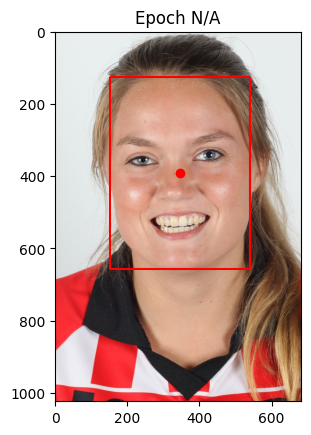

In [51]:
visualize_prediction(img_tensor, bbox, 'N/A')

Now lets train a nn on just this one image

In [52]:
img_tensor.shape

torch.Size([3, 1024, 683])

In [53]:
class cnn(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv = nn.Conv2d(3, 16, 5, padding=1)
        self.gap = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Linear(16, 5)

    def forward(self, x):
        # print(x.shape)
        x = self.conv(x)
        # print(x.shape)
        x = nn.functional.relu(x)
        gap = self.gap(x).squeeze()
        # print(gap.shape)
        x = self.fc(gap)
        return x, gap

model = cnn()
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

Epoch 0, Loss: 0.1084


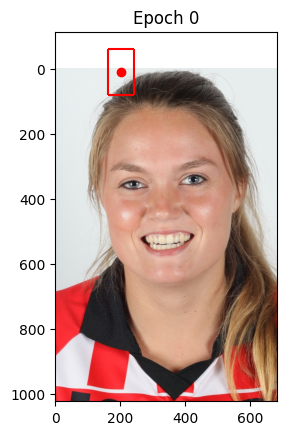

Epoch 10, Loss: 0.0081


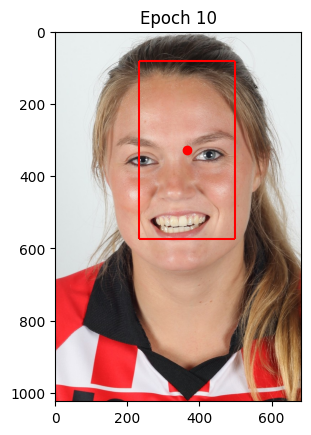

Epoch 20, Loss: 0.0010


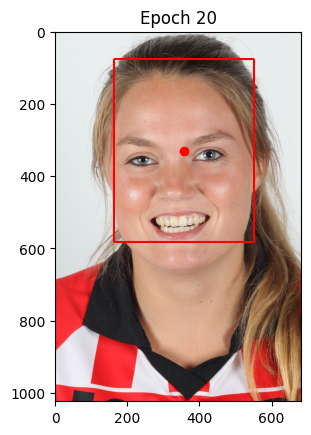

Epoch 30, Loss: 0.0005


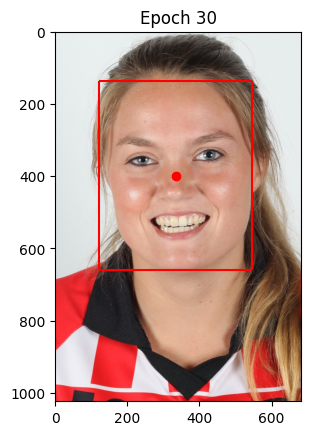

Epoch 40, Loss: 0.0005


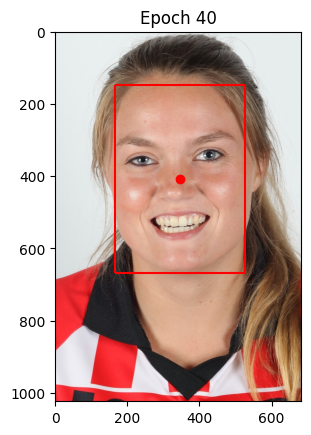

In [54]:
n_epochs = 50
for epoch in range(n_epochs):
    optimizer.zero_grad()
    output, _ = model(img_tensor)
    loss = criterion(output, bbox)
    loss.backward()
    optimizer.step()
    
    if epoch % 10 == 0 or epoch == n_epochs:
        print(f'Epoch {epoch}, Loss: {loss.item():.4f}')
        visualize_prediction(img_tensor, output.squeeze().detach(), epoch)

Sweeet we can memorize soccer lady! Now lets try out model on a never seen before img.

In [55]:
f_img = "/Users/kuba/Documents/data/Raw/Face-Detection-Dataset/images/train/79d5bf8b885efab1.jpg"
f_label = "/Users/kuba/Documents/data/Raw/Face-Detection-Dataset/labels/train/79d5bf8b885efab1.txt"

image = Image.open(f_img)

# normalizes 0 to 1
transform = transforms.ToTensor()
img_tensor = transform(image) 

with open(f_label, 'r') as f:
    label = f.readline().strip()  
    bbox = torch.tensor([float(x) for x in label.split()])

print("Image tensor shape:", img_tensor.shape)
print("Label tensor:", bbox)

Image tensor shape: torch.Size([3, 768, 1024])
Label tensor: tensor([0.0000, 0.5085, 0.5284, 0.4719, 0.7333])


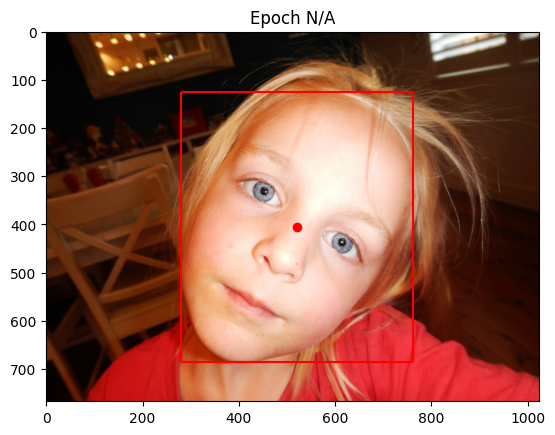

In [56]:
visualize_prediction(img_tensor, bbox, 'N/A')

In [57]:
bbox, gap = model(img_tensor)

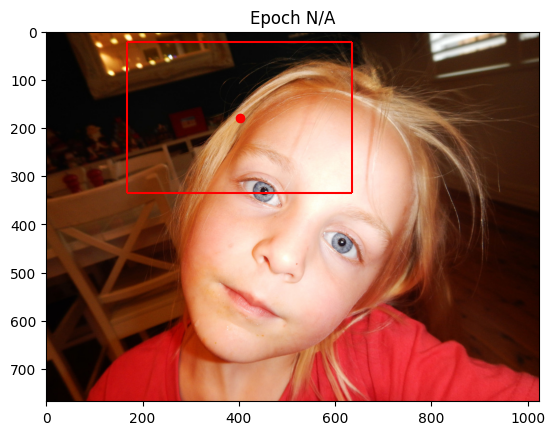

In [58]:
visualize_prediction(img_tensor, bbox, 'N/A')

Well that guess is pretty bad but our modle and train set can both get better